# Quantum Real Time Evolution using Trotterization

In this tutorial, we will study the time evolution of the [Ising model](https://en.wikipedia.org/wiki/Ising_model) on a linear lattices of $L=2$ and $L=6$ sites. These lattices consist of an array of spins $\sigma_i$ that interact only with their nearest neighbors. The numerical values that these spins take is ither $+1$ or $-1$. Let us consider the following Hamiltonian describing the dynamics of the system:

$$
H = - J \sum_{i=0}^{L-2} \sigma_i \sigma_{i+1}  - h \sum_{i=0}^{L-1} \sigma_i  \text{,}
$$

where $J$ describes the interaction energy, and $h$ the magnitude of an external field. Let us write this expression using Pauli matrices, and considering that the external field has an angle $\alpha$ with respect to the transversal direction.

$$
H = -J \sum_{i=0}^{L-2} Z_i Z_{i+1} -h \sum_{i=0}^{L-1} (\sin\alpha Z_i + \cos\alpha X_i) \text{,}
$$

In the computational basis, the system will be encoded as follows:

| Quantum state        | Spin representation |
|:--------------------:|:-------------------:|
| $| 0 0 0 0 \rangle$ | $++++$              |
| $| 1 0 0 0 \rangle$ | $-+++$              |
| $\ldots$             | $\ldots$            |
| $| 1 1 1 1 \rangle$ | $----$              |

In [1]:
from qiskit.quantum_info import SparsePauliOp
from math import sin, cos

def get_hamiltonian(L, J, h, alpha=0):
    
    # List of hamiltonian terms as 3-tuples containing
    # (1) the pauli string,
    # (2) the qubit indices corresponding to the pauli string
    # (3) the coefficient
    ZZ_tuples = [('ZZ', [i, i+1], -J) for i in range(0, L-1)]
    Z_tuples = [('Z', [i], -h * sin(alpha)) for i in range(0, L)]
    X_tuples = [('X', [i], -h * cos(alpha)) for i in range(0, L)]

    # We create the hamiltonian as a SparsePauliOp, via the
    # method from_sparse_list, and multiply by the interaction term
    hamiltonian = SparsePauliOp.from_sparse_list([*ZZ_tuples, *Z_tuples, *X_tuples], num_qubits=L)
    return hamiltonian.simplify()

In [2]:
from math import pi

L = 2
H = get_hamiltonian(L=L, J=.2, h=1., alpha=pi/8)
H

SparsePauliOp(['ZZ', 'IZ', 'ZI', 'IX', 'XI'],
              coeffs=[-0.2       +0.j, -0.38268343+0.j, -0.38268343+0.j, -0.92387953+0.j,
 -0.92387953+0.j])

Let us get started. First of all, let us create the Hamiltonian as an operator:

We can now create an instance of `TrotterQRTE`:

In [3]:
from qiskit.algorithms.time_evolvers.trotterization.trotter_qrte import TrotterQRTE

trotter = TrotterQRTE()

In addition, we need one of `TimeEvolutionProblem`. Here, we can include a number of auxiliary operators that will be aditionally evaluated during the time evolution. As an initial state, we will take an arrangement where all the spins are up except the two middle ones of the lattice.

In [4]:
from qiskit.quantum_info import Statevector
from qiskit.algorithms.time_evolvers.time_evolution_problem import TimeEvolutionProblem

final_time = 1.6
initial_state = Statevector.from_label('01')

problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time)

Once we have the `TrotterQRTE` and the `TimeEvolutionProblem` instances, we can let the perform the trotterization with the method `evolve`, which returns a result.

In [5]:
result = trotter.evolve(problem)

Our evolved state is in the attribute `evolved state`, which is a `QuantumCircuit`,

In [6]:
result.evolved_state

that, like all `QuantumCircuit`s, can be turned into a `Statevector`.

In [7]:
Statevector(result.evolved_state).is_valid()

True

Let us find out the effect of the field direction after a certain a certain time.

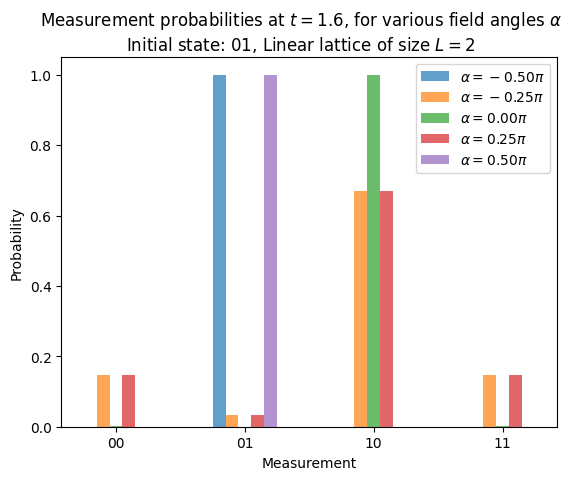

In [8]:
import numpy as np
import matplotlib.pyplot as plt

bar_width = .1
initial_state = Statevector.from_label("01")
trotter = TrotterQRTE()
final_time = 1.6
eps = 1e-5

alphas = np.linspace(-np.pi/2 + eps, np.pi/2 - eps, 5)

for i, alpha in enumerate(alphas):
    H_alpha = get_hamiltonian(L=2, J=.2, h=1., alpha=alpha)
    problem = TimeEvolutionProblem(H_alpha, initial_state=initial_state, time=1.6)
    result = trotter.evolve(problem)
    evolved_state = Statevector(result.evolved_state)
    amplitudes_dict = evolved_state.probabilities_dict()
    labels = list(amplitudes_dict.keys())
    values = list(amplitudes_dict.values())
    alpha_str = f"$\\alpha={alpha / np.pi:.2f} \\pi$"
    plt.bar(np.arange(4) + i*bar_width, values, bar_width, label=alpha_str, alpha=.7)

plt.xticks(np.arange(4) + 2 * bar_width, labels)
plt.xlabel("Measurement")
plt.ylabel("Probability")
plt.suptitle(
    f"Measurement probabilities at $t={final_time}$, for various field angles $\\alpha$\n"
    f"Initial state: 01, Linear lattice of size $L=2$"
)
plt.legend()

### Auxiliary operators

Let us look into another feature of `TrotterQRTE`. Let us explore its ability to perform time evolutions of a system, and keep track of some observables. Let us look into a larger system, $L=6$.

In [9]:
from math import pi

L = 6
H = get_hamiltonian(L=L, J=.2, h=1.2, alpha=pi/8)

The `TrotterQRTE` instance now will be created with a `num_timesteps` argument, and an `Estimator` primitive.

In [10]:
from qiskit.algorithms.time_evolvers.trotterization.trotter_qrte import TrotterQRTE
from qiskit.primitives import Estimator

num_timesteps = 60
trotter = TrotterQRTE(num_timesteps=num_timesteps, estimator=Estimator())

Let us define a *magnetization* $\sum_i Z_i$, and a *mean spin correlation* $\sum_i Z_i Z_{i+1} / (L - 1)$.

In [11]:
magnetization_op = SparsePauliOp.from_sparse_list([('Z', [i], 1.) for i in range(0, L)], num_qubits=L)
correlation_op = SparsePauliOp.from_sparse_list([('ZZ', [i], 1.) for i in range(0, L-1)], num_qubits=L) / (L - 1)

Our new initial state will have the two middle spins facing down, and the `TimeEvolutionProblem`, will incorporate some observables that will be kept track of: the Hamiltonian, as well as the

In [12]:
final_time = 30.
initial_state = Statevector.from_label('001100')
problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[H, magnetization_op, correlation_op])

In [13]:
result = trotter.evolve(problem)

The new result also features an `observables` attribute. To extract them,

In [14]:
import numpy as np

observables = np.array(np.array(result.observables)[:, :, 0])
observables.shape

(61, 3)

Text(0.5, 0, '$tJ/\\hbar$')

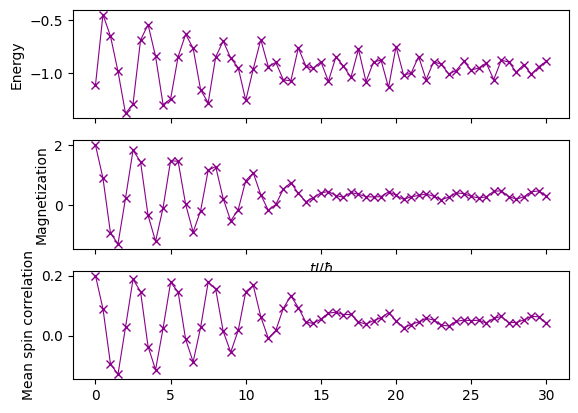

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, sharex=True)
times = np.linspace(0, final_time, num_timesteps + 1) # includes initial state
axes[0].plot(times, observables[:, 0], label='First order', marker='x', c='darkmagenta', ls='-', lw=.8)
axes[1].plot(times, observables[:, 1], label='First order', marker='x', c='darkmagenta', ls='-', lw=.8)
axes[2].plot(times, observables[:, 2], label='First order', marker='x', c='darkmagenta', ls='-', lw=.8)
axes[0].set_ylabel(r"Energy")
axes[1].set_ylabel(r"Magnetization")
axes[2].set_ylabel(r"Mean spin correlation")
axes[1].set_xlabel(r"$tJ/\hbar$")

Let us verify these results by comparing the Trotter evolution with the exact value. From Schrödinger's equation,

$$
| \psi(t) \rangle = e^{-i t H} | \psi(0) \rangle \text{.}
$$

We compute this using that we use the scipy's [`linalg.expm`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.expm.html) function.

In [16]:
import scipy as sc

H_array = H.to_matrix()

# We define a slightly denser time mesh
exact_times = np.linspace(0, final_time, 100)

# We compute the exact evolution using the exp
exact_evolution = [initial_state.evolve(sc.linalg.expm(-1j * time * H_array)) for time in exact_times]

With the exact evolution, we compute the evolution of our operators' expectation value

In [17]:
exact_energy = np.real([sv.expectation_value(H) for sv in exact_evolution])
exact_magnetization = np.real([sv.expectation_value(magnetization_op) for sv in exact_evolution])
exact_correlation = np.real([sv.expectation_value(correlation_op) for sv in exact_evolution])

Now the plot looks:

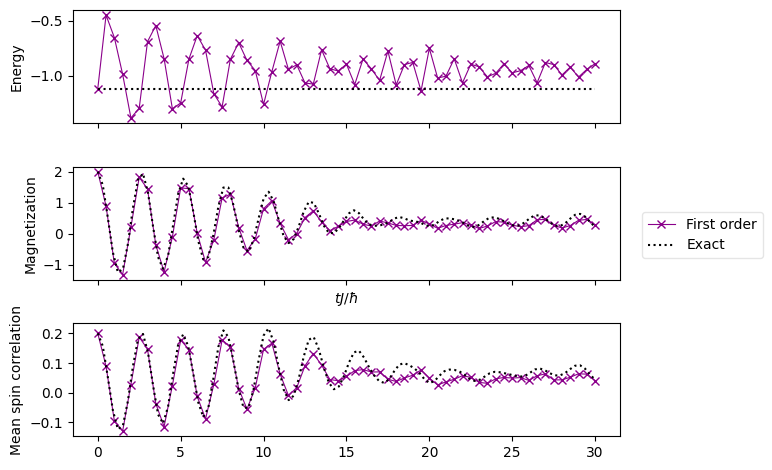

In [18]:
axes[0].plot(exact_times, exact_energy, c='k', ls=':', label='Exact')
axes[1].plot(exact_times, exact_magnetization, c='k', ls=':', label='Exact')
axes[2].plot(exact_times, exact_correlation, c='k', ls=':', label='Exact')
legend = fig.legend(*axes[0].get_legend_handles_labels(), bbox_to_anchor=(1., .5), loc='center left', framealpha=.5)
fig.tight_layout()
fig

### Product formula overview

If it isn't specified, the default product formula that `TrotterQRTE` uses is the [Lie product formula](https://en.wikipedia.org/wiki/Lie_product_formula), which is at first order.

In [19]:
trotter.product_formula

Knowing this, we can have a look at the circuit that performs a single Trotter step.


Trotter step with Lie-Trotter
-----------------------------

                  Depth: 7
             Gate count: 17
    Nonlocal gate count: 5
         Gate breakdown: RZ: 6, RX: 6, RZZ: 5



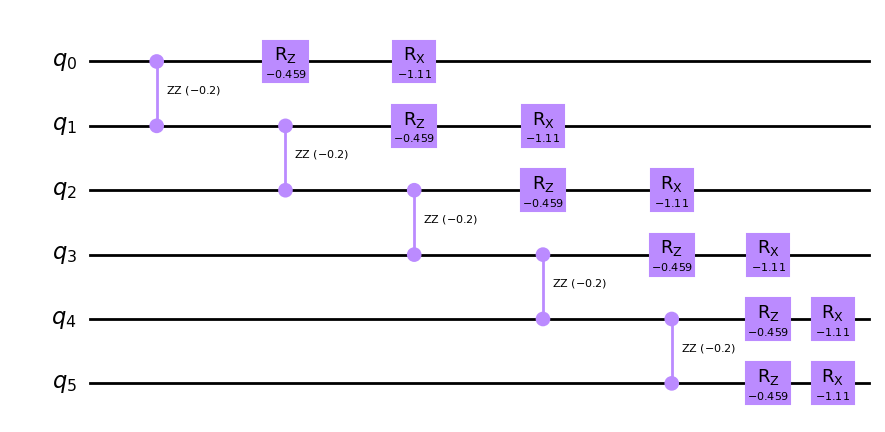

In [20]:
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import LieTrotter

dt = final_time / num_timesteps
trotter_step_first_order = PauliEvolutionGate(H, dt, synthesis=LieTrotter())

# We create an empty circuit
circuit = QuantumCircuit(H.num_qubits)
circuit.append(trotter_step_first_order, range(H.num_qubits))
circuit = circuit.decompose(reps=2)

# Let us print some stats
print(f"""
Trotter step with Lie-Trotter
-----------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}
""")

# And finally draw the circuit
circuit.draw('mpl')

If we want to increase the precision, the `SuzukiTrotter` product formula can be used, which allows for higher (even) orders.


Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: 14
             Gate count: 33
    Nonlocal gate count: 10
         Gate breakdown: RZ: 12, RX: 11, RZZ: 10




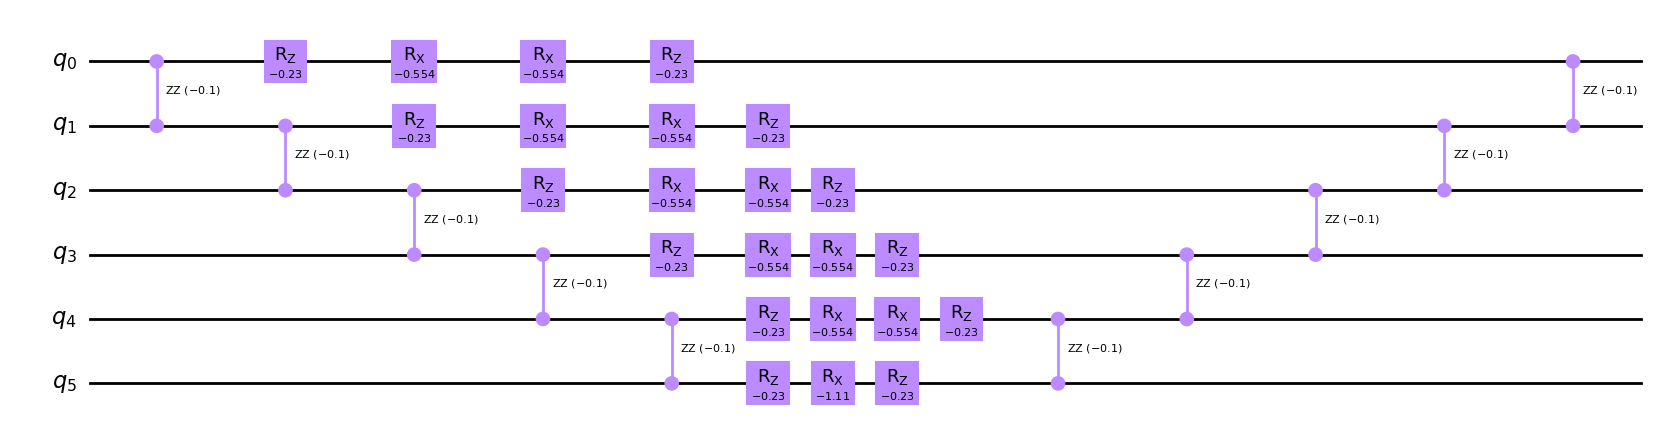

In [21]:
from qiskit.synthesis import SuzukiTrotter

second_order_formula = SuzukiTrotter()
trotter_step_second_order = PauliEvolutionGate(H, dt, synthesis=second_order_formula)
circuit = QuantumCircuit(H.num_qubits)
circuit.append(trotter_step_second_order, range(H.num_qubits))
circuit = circuit.decompose(reps=2)

# Let us print some stats
print(f"""
Trotter step with Suzuki Trotter (2nd order)
--------------------------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

""")

# And finall
circuit.draw('mpl')

In [22]:
fourth_order_formula = SuzukiTrotter(order=4)
trotter_step_fourth_order = PauliEvolutionGate(H, dt, synthesis=second_order_formula)
circuit = QuantumCircuit(H.num_qubits)
circuit.append(trotter_step_fourth_order, range(H.num_qubits))
circuit = circuit.decompose(reps=2)

# Let us print some stats
print(f"""
Trotter step with Suzuki Trotter (4th order)
--------------------------------------------

                  Depth: {circuit.depth()}
             Gate count: {len(circuit)}
    Nonlocal gate count: {circuit.num_nonlocal_gates()}
         Gate breakdown: {", ".join([f"{k.upper()}: {v}" for k, v in circuit.count_ops().items()])}

""")


Trotter step with Suzuki Trotter (4th order)
--------------------------------------------

                  Depth: 14
             Gate count: 33
    Nonlocal gate count: 10
         Gate breakdown: RZ: 12, RX: 11, RZZ: 10




Finally, let us perform a simulation at fourth order.

In [23]:
from qiskit.synthesis import SuzukiTrotter

# Now
trotter = TrotterQRTE(SuzukiTrotter(order=4), num_timesteps=num_timesteps, estimator=Estimator())
problem = TimeEvolutionProblem(H, initial_state=initial_state, time=final_time, aux_operators=[H, magnetization_op, correlation_op])
result = trotter.evolve(problem)
observables_order4 = np.array(np.array(result.observables)[:, :, 0], dtype=np.float64)

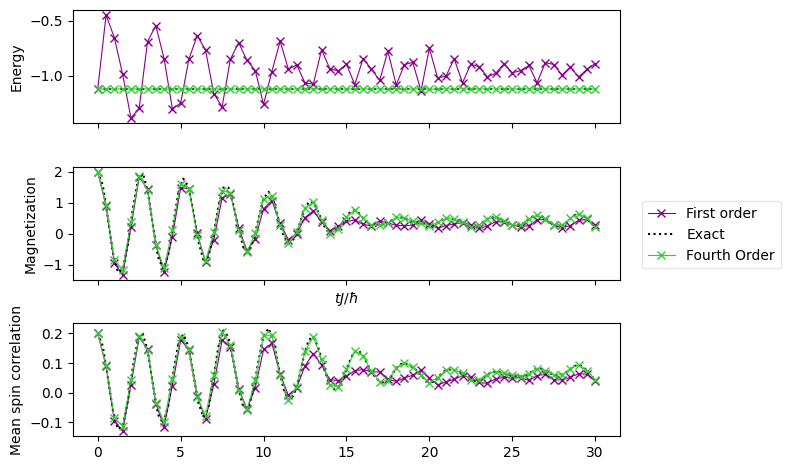

In [24]:
axes[0].plot(times, observables_order4[:, 0], label='Fourth Order', marker='x', c='limegreen', ls='-', lw=.8)
axes[1].plot(times, observables_order4[:, 1], label='Fourth Order', marker='x', c='limegreen', ls='-', lw=.8)
axes[2].plot(times, observables_order4[:, 2], label='Fourth Order', marker='x', c='limegreen', ls='-', lw=.8)
legend.remove()
legend = fig.legend(*axes[0].get_legend_handles_labels(), bbox_to_anchor=(1., .5), loc='center left', framealpha=.5)
fig

Include colorplot?

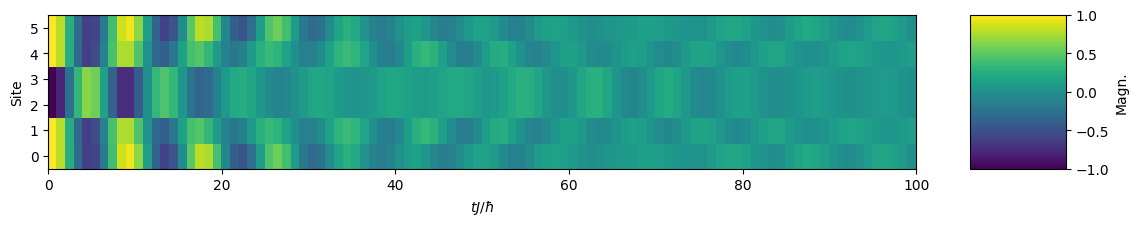

In [25]:
from matplotlib import cm

magnetizations = np.real([[sv.expectation_value(term) for term in magnetization_op] for sv in exact_evolution])
plt.figure(figsize=(14, 2))
plt.pcolor(magnetizations.T, vmin=-1, vmax=+1)
plt.yticks(np.arange(.5, 6), np.arange(6))
plt.ylabel('Site')
plt.xlabel(r'$tJ/\hbar$')
plt.colorbar(label='Magn.', aspect=1.61803399)

In [26]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

## Observations

1. All cells marked as `Raw` are supposed to go out.
2. `TrotterQRTE` doesn't implement `TimeEvolutionResult`'s `times` method. That's why they are computed here, standing alone. Is it under development/in some branch? This is PR-material (!)

## Questions
1. Include final colorplot?
2. Include an analysis of error vs. num. CNOTS or depth? How exactly?
3. Include order 2? Did only order 4 because order 2 didn't enhance visibly almost anything
4. Do `import`s at the beginning of every cell for all functions and classes that are used in the cell? Or avoid that if they were previously imported (as it is)?
5. Compare results with a backend?
